# Our goal in this notebook

In this notebook, we are going to answer the main question of the tournament, which was: 

**Given the Bitcoin price at 1 PM Pacific Time (8 PM GMT) on each Monday, what will the ROI be at the same time on the following Monday?**


After training the models and identifying the ones with the best performance in other notebooks, I will use the best ones to forecast the target value. Based on the performance of our trained models, we will proceed with using the CNN+LSTM models as well as a three-layer DNN, and we will work with both 4-hour and 8-hour datasets. When using the 4-hour data, the forecast horizon is 7*(24/4)= 42 and when using the 8-hour data, the forecast horizon is 7*(24/8) =21. Due to the long forecast horizon, each run of the models may yield different predictions. This is because we use an iterative process to forecast the ROI for each time step, and the prediction for one step is used as an input for forecasting the next step. Therefore, errors in earlier predictions can directly impact subsequent forecasts, resulting in significant variance in the predicted ROI for the following week.


To address this high-variance issue, I will run each model 50 times with different window sizes and save the results (the target value, MAE of the test set, MSE of the test set, Forecasted value for the test set, and all forecasted values for the next week (from the last time step in the test set)) in a CSV file. I also consider a metric named `MAE_Exact` which measures the mean absolute error specifically for predictions made on Mondays at 8 PM GMT. This metric is insightful because the tournament was run for four weeks and at the beginning of each week, the participants were needed to submit the weekly ROI on that Monday and the best results are those with the lowest MAE for four weeks within July.

Finally, I will combine all the results saved in CSV files into one dataframe for comparison. The analysis dataframe includes statistics like mean, median, standard deviation, and skewness for the target value of each model run. I used these metrics to compare the performance of different models and decide which one is the most reliable. The dataframe is sorted by standard deviation and `MAE_Exact_Mean` to prioritize models that show consistent predictions with low error.


## Key points 


In the following, we state some key points to be considered when using deep learning models for time series forecasting and draw inference:

1. In cases of similar performance, models with more parameters tend to be more prone to high-variance issues.

2. Using a smaller window size can help reduce the high-variance problem.

3. Using initializers (such as `RandomNormal` for the convolution layer and `glorot_uniform`for LSTM) in the model can help reduce the high-variance problem. Proper initialization can lead to more consistent and reliable training outcomes, thus mitigating the impact of high variance.

4. We have to retrain the model on test (or validation) data before inference. Retraining the model on test data helps it better adapt to the latest patterns in the data. This step can improve accuracy by ensuring the model is tuned to current trends before making final predictions.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings


from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
#from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, LSTM, Conv1D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.losses import Huber, LogCosh
from tensorflow.keras.initializers import RandomNormal, glorot_uniform

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("hourly_data_2024_08_02.csv", parse_dates =['time'])
df.set_index('time', inplace= True) # set `time` as index of dataframe
df = df[~df.index.duplicated(keep='first')] # drop duplicated indices
df = df[(df.index >= "2018-01-01") & (df.index <= "2024-07-30")]

# Every four hours

In [7]:
desired_hours = [0, 4, 8, 12, 16, 20]
df_4h= df[(df.index >= "2014-07-01") & (df.index < "2024-07-30")][["close"]]

df_4h = df_4h[df_4h.index.hour.isin(desired_hours)]
df_4h

,close
time,
2018-01-01 00:00:00,13642.93
2018-01-01 04:00:00,13631.46
2018-01-01 08:00:00,13493.98
2018-01-01 12:00:00,13229.17
2018-01-01 16:00:00,13078.93
...,...
2024-07-29 04:00:00,69365.67
2024-07-29 08:00:00,69463.36
2024-07-29 12:00:00,69803.41


In [8]:
def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out


df_roi= roi_df(df_4h, day=0, hour = 0)
df_roi4= roi_df(df_4h, day=0, hour = 4)
df_roi8= roi_df(df_4h, day=0, hour = 8)
df_roi12 = roi_df(df_4h, day =0, hour =12)
df_roi16= roi_df(df_4h, day=0, hour = 16)
df_roi20 = roi_df(df_4h, day =0, hour =20)

df_roi = pd.concat([df_roi, df_roi8, df_roi12,df_roi16,df_roi20,df_roi4])

for d in range(1,8):
    for i in range(6):
        df_roi_new = roi_df(df_4h, day=d, hour = i*4)
        df_roi = pd.concat([df_roi, df_roi_new])
    


df_roi = df_roi.sort_index()#(by='time').reset_index(drop=True)

df_roi.index.name = "time"
df_roi

,7_Day_ROI
time,
2018-01-01 00:00:00,17.248128
2018-01-01 04:00:00,15.253098
2018-01-01 08:00:00,14.969268
2018-01-01 12:00:00,16.635586
2018-01-01 16:00:00,13.787213
...,...
2024-07-22 04:00:00,2.102873
2024-07-22 08:00:00,3.530154
2024-07-22 12:00:00,3.088608


In [9]:
split = pd.to_datetime("2023-12-31 20:00:00")
train = df_roi.loc[: split]
test  = df_roi.loc[split + timedelta(hours = 4):]
split_index = len(train)
print("Number of data in train:", len(train))
print("Number of data in test:", len(test))

exact_test  = test[(test.index.hour == 20) &(test.index.weekday == 0)]

Number of data in train: 13146
Number of data in test: 1224


In [10]:
test

,7_Day_ROI
time,
2024-01-01 00:00:00,2.822069
2024-01-01 04:00:00,2.897226
2024-01-01 08:00:00,3.153144
2024-01-01 12:00:00,5.860147
2024-01-01 16:00:00,5.258551
...,...
2024-07-22 04:00:00,2.102873
2024-07-22 08:00:00,3.530154
2024-07-22 12:00:00,3.088608


## CNN+LSTM

In [12]:
forecast_horizen = 42
verbose = 0
window_size = 12
batch_size = 512
epochs_train = 15
epochs_retrain = 6
filters= 32
units =64
save_path = f"50_runs_results\\4H_window{window_size}_conv{filters}_lstm{units}_initializer.csv"
no_runs = 50



def preprocessing(data, window_size, batch_size, shuffle_buffer_size, shift=1 ):
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    feature_label = dataset.map(lambda window: (window[:-1], window[-1]))
    feature_label = feature_label.shuffle(buffer_size=shuffle_buffer_size)
    feature_label = feature_label.batch(batch_size).prefetch(1)
    return feature_label



def make_prediction(dataframe, model, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True):
    '''
    dataframe must be the Pandas series or numpy array of the whole(train and test) variable
    split_index = len(train)
    '''
    if isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.reset_index(inplace=True)
    
    forecast = []
    if test:
        start_index = split_index-window_size+1
        no_windows = len(dataframe)-start_index-window_size+1
        time = dataframe[time_feature][split_index: ]
        #print(start_index)
        #print(no_windows)
    else:
        start_index = 0
        no_windows = split_index-window_size+1
        time = dataframe[time_feature][window_size-1:split_index]

    if len(time) == no_windows:
        for i in range(start_index, start_index+no_windows):
            forecast.append(model.predict(dataframe[feature_name][i:window_size-1+i].values[np.newaxis], verbose = verbose))

    else:
        raise Exception("Not equal number of time stamps and number of windows")
    

    return time, np.array(forecast).squeeze()



feature_label_train = preprocessing(train["7_Day_ROI"], window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

feature_label_test = preprocessing(test["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

#feature_label = preprocessing(df_roi["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(df_roi), shift=1 )

mae = []
mse = []
mae_exact = []
target_roi = []
weekly_roi =[]
forecaste_list = []

for i in tqdm(range(no_runs)):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Conv1D(filters = filters, kernel_size = 3, activation = 'relu', input_shape = [window_size-1, 1], kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(LSTM(units =units, return_sequences = False, kernel_initializer=glorot_uniform(seed=None)))
    model.add(Dense(1))
    model.add(Lambda(lambda x: x*10))

    model.compile(optimizer = SGD(learning_rate= 5.5e-5, momentum = .9), loss = "mse", metrics = ["mae"])
    history = model.fit(feature_label_train, epochs = epochs_train, validation_data=feature_label_test, verbose= verbose)


    time_test, forecast_test= make_prediction(df_roi, model = model, test=True)
    forecast_exact = forecast_test[5::42]

    mae.append(mean_absolute_error(test["7_Day_ROI"].values, forecast_test))

    mse.append(mean_squared_error(test["7_Day_ROI"].values, forecast_test))
    
    mae_exact.append(mean_absolute_error(exact_test["7_Day_ROI"].values, forecast_exact))
    
    forecaste_list.append(forecast_test)
    # retrain on test data
    model.fit(feature_label_test, epochs = epochs_retrain, verbose = verbose)

    # make prediction
    input_data = df_roi["7_Day_ROI"].iloc[-window_size+1:].values[np.newaxis]
    predicted_rois = []
    current_input = input_data

    for i in range(forecast_horizen):
        # Predict the next day's ROI
        predicted_roi = model.predict(current_input, verbose = verbose)[0][0]
        
        # Append the predicted ROI to the list of predictions
        predicted_rois.append(predicted_roi)
        
        # Update the current_input with the new predicted ROI
        current_input = np.append(current_input[:, 1:], [[predicted_roi]], axis=1) 

    weekly_roi.append(predicted_rois)
    target_roi.append(round(predicted_rois[forecast_horizen-1],5))


data = {"Target": target_roi, "MAE": mae, "MSE": mse, "MAE_Exact": mae_exact, "Weekly_ROI": weekly_roi, "Week_Forecast":forecaste_list }

df_result = pd.DataFrame(data)

df_result.to_csv(save_path, index = False)




100%|██████████| 50/50 [50:08<00:00, 60.17s/it]


 Mean of target values: -0.3082288
Standard deviation of target values: 1.2721274
Meadin of target values: -0.40292


<Axes: ylabel='Density'>

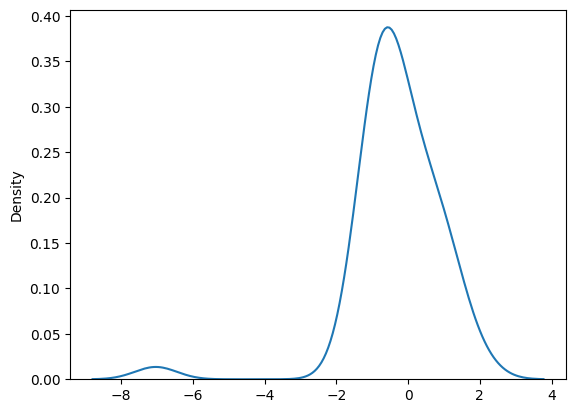

In [8]:
print(" Mean of target values:",np.mean(np.array(target_roi)))
print("Standard deviation of target values:",np.std(np.array(target_roi)))
print("Meadin of target values:", np.median(np.array(target_roi)))

sns.kdeplot(target_roi)

## 3 Layer DNN

In [16]:
forecast_horizen = 42
verbose = 0
window_size = 12
batch_size = 512
epochs_train = 100
epochs_retrain = 20
save_path = f"50_runs_results\\4H_window{window_size}_3layer_NN.csv"
no_runs = 50



def preprocessing(data, window_size, batch_size, shuffle_buffer_size, shift=1 ):
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    feature_label = dataset.map(lambda window: (window[:-1], window[-1]))
    feature_label = feature_label.shuffle(buffer_size=shuffle_buffer_size)
    feature_label = feature_label.batch(batch_size).prefetch(1)
    return feature_label



def make_prediction(dataframe, model, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True):
    '''
    dataframe must be the Pandas series or numpy array of the whole(train and test) variable
    split_index = len(train)
    '''
    if isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.reset_index(inplace=True)
    
    forecast = []
    if test:
        start_index = split_index-window_size+1
        no_windows = len(dataframe)-start_index-window_size+1
        time = dataframe[time_feature][split_index: ]
        #print(start_index)
        #print(no_windows)
    else:
        start_index = 0
        no_windows = split_index-window_size+1
        time = dataframe[time_feature][window_size-1:split_index]

    if len(time) == no_windows:
        for i in range(start_index, start_index+no_windows):
            forecast.append(model.predict(dataframe[feature_name][i:window_size-1+i].values[np.newaxis], verbose = verbose))

    else:
        raise Exception("Not equal number of time stamps and number of windows")
    

    return time, np.array(forecast).squeeze()



feature_label_train = preprocessing(train["7_Day_ROI"], window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

feature_label_test = preprocessing(test["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

#feature_label = preprocessing(df_roi["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(df_roi), shift=1 )

mae = []
mse = []
mae_exact = []
target_roi = []
weekly_roi =[]
forecaste_list = []

for i in tqdm(range(no_runs)):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Dense(20, activation = 'relu', input_shape = [window_size-1]))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))


    model.compile(loss = 'mse', metrics = ["mae"], optimizer = SGD(learning_rate=1e-5, momentum =0.9))
    history = model.fit(feature_label_train, epochs = epochs_train, verbose= verbose)


    time_test, forecast_test= make_prediction(df_roi, model = model, test=True)
    forecast_exact = forecast_test[5::42]

    mae.append(mean_absolute_error(test["7_Day_ROI"].values, forecast_test))

    mse.append(mean_squared_error(test["7_Day_ROI"].values, forecast_test))
    
    mae_exact.append(mean_absolute_error(exact_test["7_Day_ROI"].values, forecast_exact))
    
    forecaste_list.append(forecast_test)
    # retrain on test data
    model.fit(feature_label_test, epochs = epochs_retrain, verbose = verbose)

    # make prediction
    input_data = df_roi["7_Day_ROI"].iloc[-window_size+1:].values[np.newaxis]
    predicted_rois = []
    current_input = input_data

    for i in range(forecast_horizen):
        # Predict the next day's ROI
        predicted_roi = model.predict(current_input, verbose = verbose)[0][0]
        
        # Append the predicted ROI to the list of predictions
        predicted_rois.append(predicted_roi)
        
        # Update the current_input with the new predicted ROI
        current_input = np.append(current_input[:, 1:], [[predicted_roi]], axis=1) 

    weekly_roi.append(predicted_rois)
    target_roi.append(round(predicted_rois[forecast_horizen-1],5))


data = {"Target": target_roi, "MAE": mae, "MSE": mse, "MAE_Exact": mae_exact, "Weekly_ROI": weekly_roi, "Week_Forecast":forecaste_list }

df_result = pd.DataFrame(data)

df_result.to_csv(save_path, index = False)




100%|██████████| 50/50 [1:18:38<00:00, 94.37s/it]


 Mean of target values: -0.44568017
Standard deviation of target values: 1.1395137
Meadin of target values: -0.50678


<Axes: ylabel='Density'>

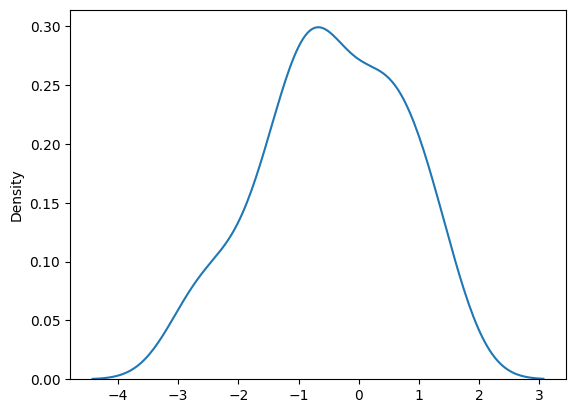

In [17]:
print(" Mean of target values:",np.mean(np.array(target_roi)))
print("Standard deviation of target values:",np.std(np.array(target_roi)))
print("Meadin of target values:", np.median(np.array(target_roi)))

sns.kdeplot(target_roi)

# Every eight hour

In [37]:
df_8h = df[(df.index.hour == 4) | (df.index.hour == 12)  | (df.index.hour == 20)][["close"]]
df_8h= df_8h[(df_8h.index >= "2016-07-01") & (df_8h.index <= "2024-07-30")]
df_8h

,close
time,
2018-01-01 04:00:00,13631.46
2018-01-01 12:00:00,13229.17
2018-01-01 20:00:00,13464.52
2018-01-02 04:00:00,13126.32
2018-01-02 12:00:00,13625.40
...,...
2024-07-28 12:00:00,68006.87
2024-07-28 20:00:00,68007.47
2024-07-29 04:00:00,69365.67


In [38]:
def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out


df_roi= roi_df(df_8h, day=0, hour = 4)
df_roi12 = roi_df(df_8h, day =0, hour =12)
df_roi20 = roi_df(df_8h, day =0, hour =20)
df_roi = pd.concat([df_roi, df_roi12, df_roi20])

for d in range(1,8):
    df_roi_new4= roi_df(df_8h, day=d, hour = 4)
    df_roi_new12= roi_df(df_8h, day=d, hour = 12)
    df_roi_new20= roi_df(df_8h, day=d, hour = 20)

    df_roi = pd.concat([df_roi, df_roi_new4, df_roi_new12, df_roi_new20])
    


df_roi = df_roi.sort_index()#(by='time').reset_index(drop=True)

df_roi.index.name = "time"
df_roi

,7_Day_ROI
time,
2018-01-01 04:00:00,15.253098
2018-01-01 12:00:00,16.635586
2018-01-01 20:00:00,11.286552
2018-01-02 04:00:00,17.149285
2018-01-02 12:00:00,8.509108
...,...
2024-07-21 12:00:00,1.576866
2024-07-21 20:00:00,0.391825
2024-07-22 04:00:00,2.102873


## CNN+ LSTM

In [23]:
forecast_horizen = 21
verbose = 0
window_size = 4
batch_size = 256
epochs_train = 30
epochs_retrain = 7
filters= 32
units =64
save_path = f"50_runs_results\\8H_window{window_size}_con{filters}_lstm{units}_initializer.csv"
no_runs = 50


#df_roi.set_index("time")
split = pd.to_datetime("2023-12-31 20:00:00")
split_index = df_roi.index.get_loc(split)
train = df_roi.loc[: split]
test  = df_roi.loc[split + timedelta(hours = 8):]
split_index = len(train)
exact_test  = test[(test.index.hour == 20) &(test.index.weekday == 0)]



def preprocessing(data, window_size, batch_size, shuffle_buffer_size, shift=1 ):
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    feature_label = dataset.map(lambda window: (window[:-1], window[-1]))
    feature_label = feature_label.shuffle(buffer_size=shuffle_buffer_size)
    feature_label = feature_label.batch(batch_size).prefetch(1)
    return feature_label
tf.keras.backend.clear_session()



def make_prediction(dataframe, model, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True):
    '''
    dataframe must be the Pandas series or numpy array of the whole(train and test) variable
    split_index = len(train)
    '''
    if isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.reset_index(inplace=True)
    
    forecast = []
    if test:
        start_index = split_index-window_size+1
        no_windows = len(dataframe)-start_index-window_size+1
        time = dataframe[time_feature][split_index: ]
        #print(start_index)
        #print(no_windows)
    else:
        start_index = 0
        no_windows = split_index-window_size+1
        time = dataframe[time_feature][window_size-1:split_index]

    if len(time) == no_windows:
        for i in range(start_index, start_index+no_windows):
            forecast.append(model.predict(dataframe[feature_name][i:window_size-1+i].values[np.newaxis], verbose = verbose))

    else:
        raise Exception("Not equal number of time stamps and number of windows")
    

    return time, np.array(forecast).squeeze()



feature_label_train = preprocessing(train["7_Day_ROI"], window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

feature_label_test = preprocessing(test["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

#feature_label = preprocessing(df_roi["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(df_roi), shift=1 )

mae = []
mse = []
mae_exact = []
target_roi = []
weekly_roi =[]
forecaste_list = []

for i in tqdm(range(no_runs)):
    model = Sequential()
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = 'relu', input_shape = [window_size-1, 1], kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(LSTM(units =units, return_sequences = False, kernel_initializer=glorot_uniform(seed=None)))
    model.add(Dense(1))
    model.add(Lambda(lambda x: x*10))
    model.compile(optimizer = SGD(learning_rate= 5.5e-5, momentum = .9), loss = "mse", metrics = ["mae"])
    history = model.fit(feature_label_train, epochs = epochs_train, validation_data=feature_label_test, verbose= verbose)


    time_test, forecast_test= make_prediction(df_roi, model = model, test=True)
    forecast_exact = forecast_test[2::21]

    mae.append(mean_absolute_error(test["7_Day_ROI"].values, forecast_test))

    mse.append(mean_squared_error(test["7_Day_ROI"].values, forecast_test))
    
    mae_exact.append(mean_absolute_error(exact_test["7_Day_ROI"].values, forecast_exact))
    
    forecaste_list.append(forecast_test)
    # retrain on test data
    model.fit(feature_label_test, epochs = epochs_retrain, verbose = verbose)

    # make prediction
    input_data = df_roi["7_Day_ROI"].iloc[-window_size+1:].values[np.newaxis]
    predicted_rois = []
    current_input = input_data

    for i in range(forecast_horizen):
        # Predict the next day's ROI
        predicted_roi = model.predict(current_input, verbose = verbose)[0][0]
        
        # Append the predicted ROI to the list of predictions
        predicted_rois.append(predicted_roi)
        
        # Update the current_input with the new predicted ROI
        current_input = np.append(current_input[:, 1:], [[predicted_roi]], axis=1) 

    weekly_roi.append(predicted_rois)
    target_roi.append(round(predicted_rois[forecast_horizen-1],5))


data = {"Target": target_roi, "MAE": mae, "MSE": mse, "MAE_Exact": mae_exact, "Weekly_ROI": weekly_roi, "Week_Forecast":forecaste_list }

df_result = pd.DataFrame(data)

df_result.to_csv(save_path, index = False)




100%|██████████| 50/50 [28:30<00:00, 34.21s/it]


 Mean of target values: -0.351067
Standard deviation of target values: 0.4789578
Meadin of target values: -0.38231498


<Axes: ylabel='Density'>

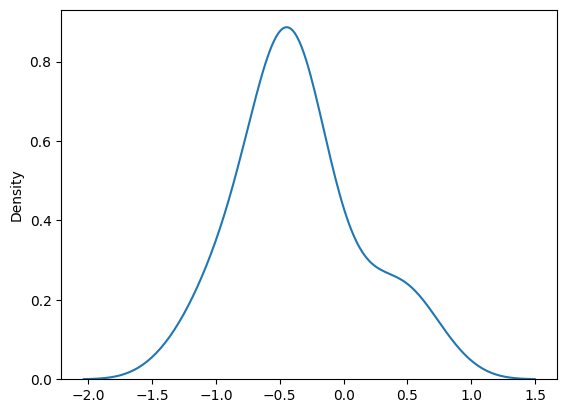

In [26]:
print(" Mean of target values:",np.mean(np.array(target_roi)))
print("Standard deviation of target values:",np.std(np.array(target_roi)))
print("Meadin of target values:", np.median(np.array(target_roi)))

sns.kdeplot(target_roi)

## 3 Layer DNN

In [39]:
forecast_horizen = 21
verbose = 0
window_size = 4
batch_size = 256
epochs_train = 120
epochs_retrain = 25
filters= 32
units =64
save_path = f"50_runs_results\\8H_window{window_size}_3layer_NN.csv"
no_runs = 50

#df_roi.set_index("time")
split = pd.to_datetime("2023-12-31 20:00:00")
split_index = df_roi.index.get_loc(split)
train = df_roi.loc[: split]
test  = df_roi.loc[split + timedelta(hours = 8):]
split_index = len(train)
exact_test  = test[(test.index.hour == 20) &(test.index.weekday == 0)]


def preprocessing(data, window_size, batch_size, shuffle_buffer_size, shift=1 ):
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    feature_label = dataset.map(lambda window: (window[:-1], window[-1]))
    feature_label = feature_label.shuffle(buffer_size=shuffle_buffer_size)
    feature_label = feature_label.batch(batch_size).prefetch(1)
    return feature_label



def make_prediction(dataframe, model, time_feature = "time", feature_name = "7_Day_ROI", window_size = window_size, split_index = split_index, verbose = verbose, test = True):
    '''
    dataframe must be the Pandas series or numpy array of the whole(train and test) variable
    split_index = len(train)
    '''
    if isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.reset_index(inplace=True)
    
    forecast = []
    if test:
        start_index = split_index-window_size+1
        no_windows = len(dataframe)-start_index-window_size+1
        time = dataframe[time_feature][split_index: ]
        #print(start_index)
        #print(no_windows)
    else:
        start_index = 0
        no_windows = split_index-window_size+1
        time = dataframe[time_feature][window_size-1:split_index]

    if len(time) == no_windows:
        for i in range(start_index, start_index+no_windows):
            forecast.append(model.predict(dataframe[feature_name][i:window_size-1+i].values[np.newaxis], verbose = verbose))

    else:
        raise Exception("Not equal number of time stamps and number of windows")
    

    return time, np.array(forecast).squeeze()



feature_label_train = preprocessing(train["7_Day_ROI"], window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

feature_label_test = preprocessing(test["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(train), shift=1 )

#feature_label = preprocessing(df_roi["7_Day_ROI"].values,  window_size = window_size, batch_size= batch_size, shuffle_buffer_size = len(df_roi), shift=1 )

mae = []
mse = []
mae_exact = []
target_roi = []
weekly_roi =[]
forecaste_list = []

for i in tqdm(range(no_runs)):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Dense(20, activation = 'relu', input_shape = [window_size-1]))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))


    model.compile(loss = 'mse', metrics = ["mae"], optimizer = SGD(learning_rate=1e-5, momentum =0.9))
    history = model.fit(feature_label_train, epochs = epochs_train, verbose= verbose)


    time_test, forecast_test= make_prediction(df_roi, model = model, test=True)
    forecast_exact = forecast_test[2::21]

    mae.append(mean_absolute_error(test["7_Day_ROI"].values, forecast_test))

    mse.append(mean_squared_error(test["7_Day_ROI"].values, forecast_test))
    
    mae_exact.append(mean_absolute_error(exact_test["7_Day_ROI"].values, forecast_exact))
    
    forecaste_list.append(forecast_test)
    # retrain on test data
    model.fit(feature_label_test, epochs = epochs_retrain, verbose = verbose)

    # make prediction
    input_data = df_roi["7_Day_ROI"].iloc[-window_size+1:].values[np.newaxis]
    predicted_rois = []
    current_input = input_data

    for i in range(forecast_horizen):
        # Predict the next day's ROI
        predicted_roi = model.predict(current_input, verbose = verbose)[0][0]
        
        # Append the predicted ROI to the list of predictions
        predicted_rois.append(predicted_roi)
        
        # Update the current_input with the new predicted ROI
        current_input = np.append(current_input[:, 1:], [[predicted_roi]], axis=1) 

    weekly_roi.append(predicted_rois)
    target_roi.append(round(predicted_rois[forecast_horizen-1],5))


data = {"Target": target_roi, "MAE": mae, "MSE": mse, "MAE_Exact": mae_exact, "Weekly_ROI": weekly_roi, "Week_Forecast":forecaste_list }

df_result = pd.DataFrame(data)

df_result.to_csv(save_path, index = False)




100%|██████████| 50/50 [45:03<00:00, 54.07s/it]


# Analysis of results

In [40]:
import os

path = "50_runs_results"

files_in_path = [f for f in os.listdir(path)]

dataframes = {}

for i,f in enumerate(files_in_path):
    file_path = os.path.join(path, f)
    dataframes[i+1] = pd.read_csv(file_path)


In [41]:
means =[]
stds = []
medians = []
mae_exact_mean =[]
medians_first_half =[]
medians_second_half = []
ranges=[]
mae_mean = []
skewness = []

for i in range(len(files_in_path)):
    means.append(np.mean(dataframes[i+1]["Target"]))
    medians_first_half.append(np.median(dataframes[i+1]["Target"][:25]))
    medians_second_half.append(np.median(dataframes[i+1]["Target"][25:]))
    ranges.append(np.max(dataframes[i+1]["Target"])-np.min(dataframes[i+1]["Target"]))
    stds.append(np.std(dataframes[i+1]["Target"]))
    medians.append(np.median(dataframes[i+1]["Target"]))
    skewness.append(dataframes[i+1]["Target"].skew())
    try:
        mae_mean.append(np.mean(dataframes[i+1]["MAE"]))
    except:
        mae_mean.append(np.NAN)
    try:
        mae_exact_mean.append(np.mean(dataframes[i+1]["MAE_Exact"]))
    except:
        mae_exact_mean.append(np.NAN)

analysis_df = pd.DataFrame({"Run":files_in_path,
                            "Mean": means, 
                            "Median1": medians_first_half,
                            "Median2": medians_second_half,
                            "Median": medians, 
                            "std":stds, 
                            "skewness": skewness,
                            "Range": ranges,
                            "MAE": mae_mean,
                            "MAE_Exact_Mean": mae_exact_mean }).sort_values(["std", "MAE_Exact_Mean"], ascending=True)

analysis_df

,Run,Mean,Median1,Median2,Median,std,skewness,Range,MAE,MAE_Exact_Mean
5,8H_window4_con32_lstm64_initializer.csv,-0.351067,-0.28650,-0.49687,-0.382315,0.478958,0.459561,2.20354,1.671820,3.218018
6,8H_window9_con32_lstm64_initializer.csv,-0.098133,-0.40745,-0.05715,-0.228830,0.548808,0.406314,1.97604,1.682177,3.206139
4,8H_window4_3layer_NN.csv,0.101904,0.19485,-0.20963,-0.097860,0.714713,0.235984,3.20287,1.665883,3.231648
1,4H_window12_conv32_lstm64_initializer.csv,-0.260333,-0.35242,-0.27687,-0.329275,0.724610,0.386672,3.37944,1.192936,1.517504
2,4H_window21_3layer_NN.csv,0.005879,0.10148,0.01926,0.098365,0.893201,0.573956,4.36555,1.320311,1.814492
0,4H_window12_3layer_NN.csv,-0.445680,-0.73544,0.20225,-0.506780,1.139514,-0.268191,4.33542,1.258257,1.675142
3,4H_window21_conv32_lstm64_initializer.csv,-0.308229,0.03341,-0.69697,-0.402920,1.272127,-2.727716,9.04873,1.199219,1.526782


Considering all the metrics above, it seems the CNN+LSTM model trained on every four-hour data is a better choice to report. Since the data is not skewed,  its mean = -0.260 is our forecast for the weekly ROI of August 5th, 2024.